In [1]:
# Importing necessary libraries
import os
import pickle
import re
import spacy
import random
import nltk
from nltk.corpus import stopwords
import pandas as pd
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
#spacy.cli.download("en_core_web_sm")
import gensim
import gensim.corpora as corpora
from gensim import corpora, models
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models  
import matplotlib.pyplot as plt

In [3]:
import os

my_dict = {} # Initializing dictionary to store document texts
total_scores = {} # Initializing dictionary to store total scores
country_topics = {} # Initializing dictionary to store topics for each country

#Define function to read files from a directory
def readFiles(file_path):
    allFiles = listAllFiles(file_path)
    for f in allFiles:
        if '.DS' in f:
            continue

        pdf_file = open(os.path.join(file_path, f), 'r', encoding='utf-8')
        to_pdf = pdf_file.read()
        my_dict[f.replace('.txt', '')] = to_pdf
        total_scores[f.replace('.txt', '')] = {}
        country_topics[f.replace('.txt', '')] = {}

directory_path = r''

# Defining function to list all files in a directory
def listAllFiles(path):
    return os.listdir(path)


my_dict={}
df = pd.DataFrame()

file_path=directory_path
readFiles(file_path)

# Initializing dictionary to store paragraph texts
my_dict_paragraph={} 

#split into paragraphs based on two new line characters
for k,i in my_dict.items():
    sentences=i.split('\n\n')
    for count in range(0,len(sentences)-1):
        my_dict_paragraph[k + str(count)]=sentences[count]

df['country'] = my_dict_paragraph.keys()
df['text'] = my_dict_paragraph.values()
#df.head()

In [4]:
# Define function for calculating the coherence score
def coherence_score(dictionary, corpus, texts, start, limit, step):

    coherence_values = []
    model_list = []

    for num_topics in range(start, limit, step):

        print('Number of Topics: ', num_topics)
        model = models.LdaModel(corpus, num_topics=num_topics,
                                  id2word=dictionary_LDA,
                                  passes=75, alpha=1,
                                  eta=[0.01]*len(dictionary_LDA.keys()))
        model_list.append(model)
        coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())

        # print the extracted topics
        for i,topic in model.show_topics(formatted=True, num_topics=num_topics, num_words=20):
            print(str(i)+": "+ topic)
            print()
        print(coherence_model.get_coherence())

    return model_list, coherence_values

#define function for constructing bigrams
def bigrams_construct(texts):
    return [bigram_mod[doc] for doc in texts]

#define function for lemmatization
def lemmatization(texts, allowed_postags=['NOUN','ADJ','ADV']):
    
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])

    return texts_out

In [5]:
#Stopword removal 
nlp = spacy.load("en_core_web_sm")
stop_words = stopwords.words('english')
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
# country names and subsequent adjectives related to origin removal
countries_stopwords = ['USA','america', 'US', 'arab','emirates','australia','austria','brazil','bulgaria', 'canada','china','czech','republic','denmark','egypt','estonia','finland','france','germany','hungary',
'india','ireland','italy','japan','korea','lithuania','luxembourg','malta','mauritius','mexico','netherlands','norway','peru','poland','portugal','russia','saudi','arabia','serbia',
'singapore','slovenia','spain','sweden','turkey','united','kingdom','uruguay','vietnam']
countries_adj = ['english','german','spanish', 'austrian','swedish', 'brazilian','bulgarian','chinese','french','italian','norwegian','australian','russian','finnish','estonian','indian','estonian',
                       'lithuanian','portuguese','maltese','american','slovenian','egyptian','mexican','danish','dutch','turkish','american', 'vietnamese','koreans', 'korean']
stop_words.extend(countries_stopwords)
stop_words.extend(countries_adj)
stop_words.extend(['http','https','federal','artificial','intelligence', 'ai', '(ii)', '(i)', '(iii)', '(v)', '(iv)', '(vi)', '(vii)','(viii)'])
stop_words.extend(spacy_stopwords)

# Remove punctuation from the corpus
df['clean_doc'] = df['text'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

# Removing everything except alphabets
df['clean_doc'] = df['clean_doc'].str.replace(r'[^a-zA-Z ]', '')

# Remove short words - This is a list comprehension that filters out words with a length less than or equal to 3 characters.
df['clean_doc'] = df['clean_doc'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

# Convert all text to lowercase
df['clean_doc'] = df['clean_doc'].apply(lambda x: x.lower())

# Remove any numbers from each element in the series
df['clean_doc'] = df['clean_doc'].replace(to_replace=r'\d', value='', regex=True)

# Text tokenization
tokenized_doc = df['clean_doc'].apply(lambda x: x.split())
df['tokenized_doc'] = df['clean_doc'].apply(lambda x: x.split())

#Remove stop-words
df['tokenized_doc'] = df['tokenized_doc'].apply(lambda x: [word for word in x if word not in stop_words])

# Remove rows with empty lists (paragraphs)
df = df[df['tokenized_doc'].apply(lambda x: len(x) > 0)]
# Reset the index and drop the existing index column
df = df.reset_index(drop=True)
#df

In [6]:
data_words = df['tokenized_doc']
ps = PorterStemmer()
#de-tokenization
detokenized_doc = []
for i in range(len(df)):
    t = ' '.join(df['tokenized_doc'][i])
    detokenized_doc.append(ps.stem(t))

df['clean_doc2'] = detokenized_doc


# Bigram/trigram detection
bigram = gensim.models.Phrases(data_words,threshold=80) # higher threshold fewer phrases.
bigram_mod = gensim.models.phrases.Phraser(bigram)   
trigram = gensim.models.Phrases(bigram[data_words], threshold=1)
bigram_det = gensim.models.phrases.Phraser(bigram)
trigram_det = gensim.models.phrases.Phraser(trigram)


data_words_bigrams = bigrams_construct(data_words)
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# keep only nouns, adjectives and adverbs
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN','ADJ','ADV'])

Text(0.5, 1.0, 'WordCloud')

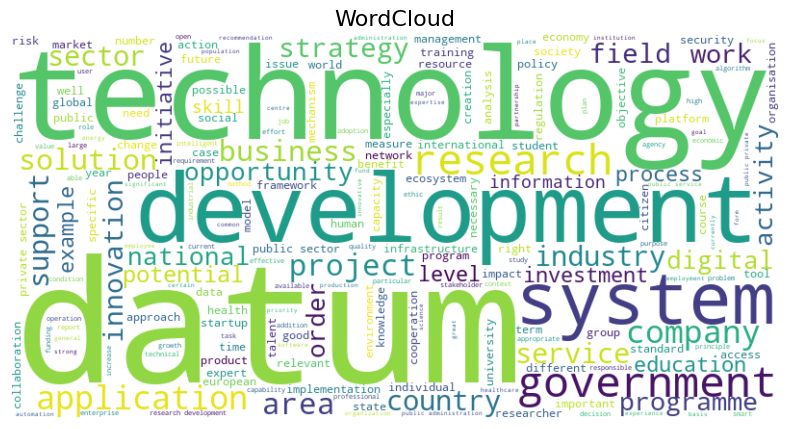

In [7]:
# Combine all words into a single string
all_words = ' '.join([' '.join(text) for text in data_lemmatized])

# Create the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Remove axis
plt.title('WordCloud', fontsize=16)
plt.show()

In [8]:
#Initialize the LDA model
dictionary_LDA = corpora.Dictionary(data_lemmatized)
dictionary_LDA.filter_extremes()

texts = data_lemmatized
corpus = [dictionary_LDA.doc2bow(text) for text in texts]

# Run the topic model for 20 topics and calculate the coherence score
limit=21; start=2; step=1;
model_list, coherence_values = coherence_score(dictionary=dictionary_LDA, corpus=corpus, texts=data_lemmatized, start=start, limit=limit, step=step)

#  Topics graph with relevant coherence scores
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.savefig('coherenceScores.jpg')